# Portfolio Strategy Analysis: CPPI vs Buy & Hold

## Research Question
Does a **CPPI** outperform a **Buy & Hold** benchmark over the sample period ***[2000-2023]*** in terms of risk-adjusted performance?

## Strategy Chosen
- Strategy type: **CPPI**
- Assets analyzed: **S&P 500, SPY**
- Rebalancing frequency: **[weekly/monthly]**

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import importlib
import utils
importlib.reload(utils)
from utils import *

import yfinance as yf
from datetime import datetime

## Data Import
We import price data for the following tickers:

- **S&P 500**
- **S&P U.S. Treasury Bill Index**  
- Period: **[01/01/2000 – 31/12/2023]**

In [3]:
tickers = ["SPY", "SHY"]  # S&P 500 ETF and S&P U.S. Treasury Bill Index (made of T-bills with a 1-year or less maturity)
start = "2003-01-01"
end = "2025-10-31"

all_data = {}

for ticker in tickers:
    all_data[ticker] = download_or_load(ticker, start, end)

# Optional: clear all CSV files if needed
# clear_all_csv()

[LOAD DATA] SPY already saved. Loading from CSV...
[LOAD DATA] SHY already saved. Loading from CSV...


## Raw Price Series
We plot the raw adjusted close prices to visually inspect data quality.

In [4]:
DATA_FOLDER = "../data"
all_files = [f for f in os.listdir(DATA_FOLDER) if f.endswith(".csv")]

all_data = {}

for file in all_files:
    ticker = file.replace(".csv", "")
    
    # Skip the first 2 rows which are extra headers from yfinance
    df = pd.read_csv(
        os.path.join(DATA_FOLDER, file),
        skiprows=2,         # Skip extra rows
        parse_dates=["Date"],
        index_col="Date"
    )
    
    # Rename the single column to ticker
    df.columns = [ticker]
    
    all_data[ticker] = df

# Combine all tickers
prices = pd.concat(all_data.values(), axis=1)

print(prices.head())
print(prices.tail())

                  SHY        SPY
Date                            
2003-01-02  53.461082  59.820522
2003-01-03  53.467648  60.004463
2003-01-06  53.435043  61.062004
2003-01-07  53.474163  60.910942
2003-01-08  53.519768  60.030731
                  SHY         SPY
Date                             
2025-10-24  82.846588  677.250000
2025-10-27  82.826653  685.239990
2025-10-28  82.836617  687.059998
2025-10-29  82.677132  687.390015
2025-10-30  82.687096  679.830017


## Data Cleaning
- Handle missing values  
- Check for price jumps  
- Convert prices to log or simple returns

Jumps detected in the following tickers and day:
                 SHY       SPY
Date                          
2008-10-13 -0.004406  0.145197
2008-10-28  0.001191  0.116855
2020-03-16  0.001622 -0.109423
2025-04-09 -0.000605  0.105019


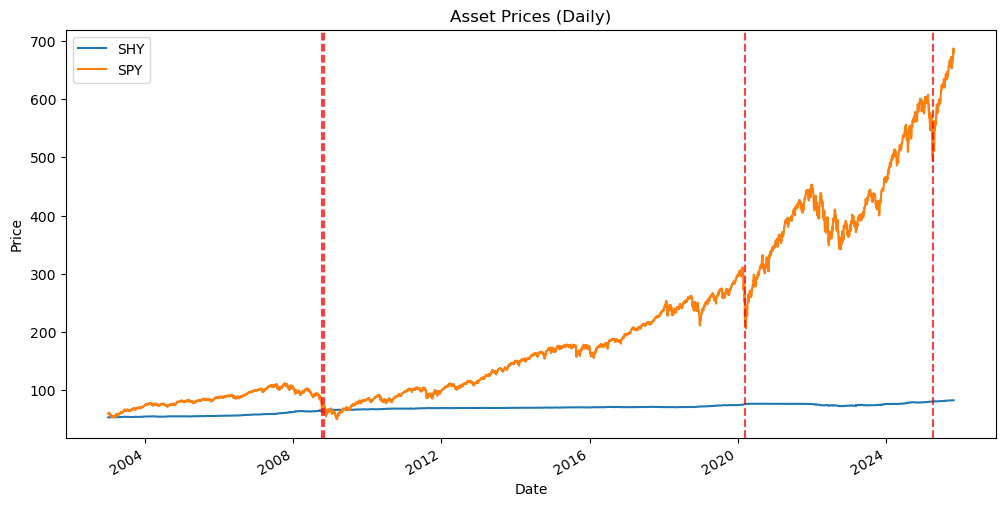

In [5]:
# Missing value handling
prices = prices.dropna()

# Log returns
returns = prices.pct_change().dropna()
returns.head()

# Weekly returns
# returns = prices.resample('W').last().pct_change().dropna()

# Check for jumps in the data
jumps = (np.abs(returns) > 0.10)
jump_days = jumps.any(axis=1)
print("Jumps detected in the following tickers and day:")
print(returns[jump_days])

# Plot prices
prices.plot(title="Asset Prices (Daily)", figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Price")
for date in jump_days[jump_days].index:
    plt.axvline(date, color='red', linestyle='--', alpha=0.75)
plt.show()

## Return Properties
We inspect return behavior: distribution, volatility, etc.

Annualized Volatility:
SHY    0.015164
SPY    0.187037
dtype: float64


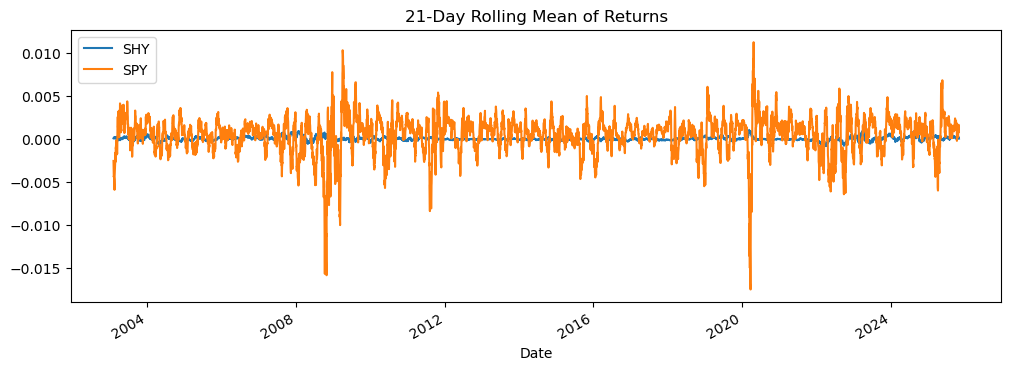

ACF for SHY


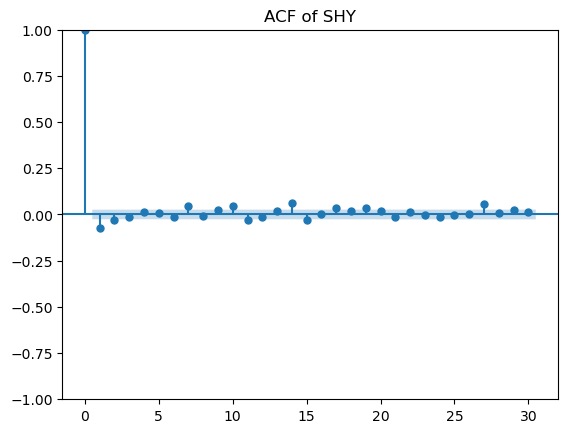

ACF for SPY


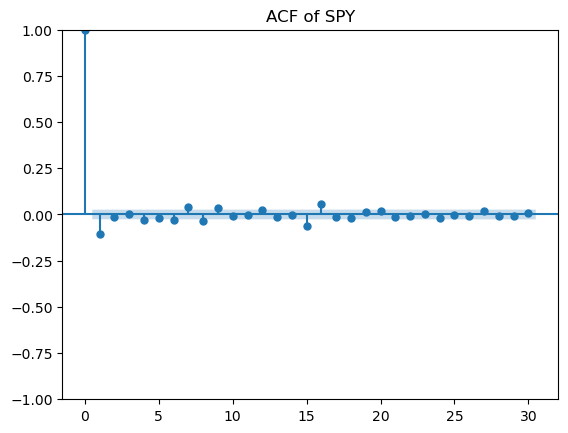

ACF of squared returns for SHY


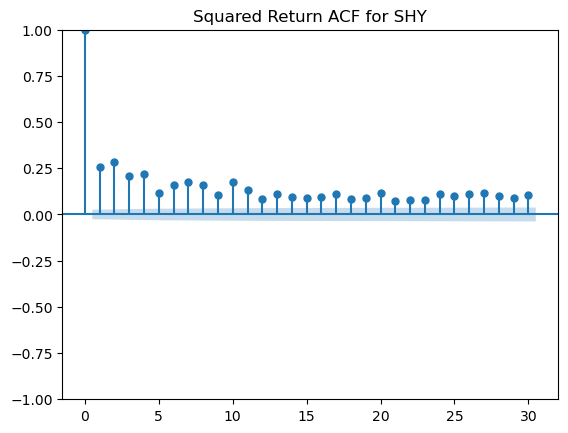

ACF of squared returns for SPY


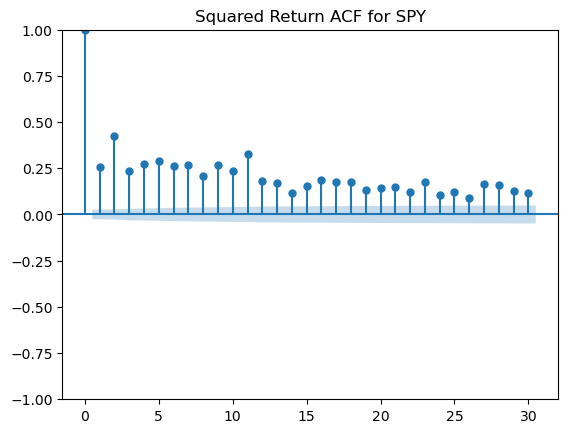

Skewness:
SHY    0.330138
SPY   -0.005244
dtype: float64
Kurtosis:
SHY     7.393631
SPY    15.288155
dtype: float64
Correlation matrix:
          SHY       SPY
SHY  1.000000 -0.225216
SPY -0.225216  1.000000
Jump frequency per asset:
SHY    0.000000
SPY    0.000696
dtype: float64
Global jump days:
DatetimeIndex(['2008-10-13', '2008-10-28', '2020-03-16', '2025-04-09'], dtype='datetime64[ns]', name='Date', freq=None)


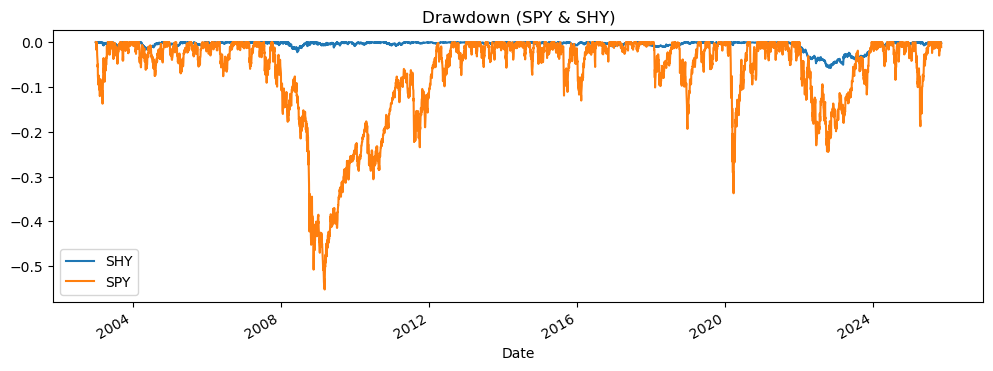

Sharpe Ratios:
SHY    0.000000
SPY    0.560884
dtype: float64


,SHY,SPY
Date,,
2003-01-03,0.000123,0.003075
2003-01-06,-0.000610,0.017624
2003-01-07,0.000732,-0.002474
2003-01-08,0.000853,-0.014451
2003-01-09,-0.001827,0.015538


In [6]:
# Annualized volatility
ann_vol = returns.std() * np.sqrt(252)
print("Annualized Volatility:")
print(ann_vol)

# Rolling mean (21-day)
roll_mean = returns.rolling(21).mean()
roll_mean.plot(figsize=(12,4), title="21-Day Rolling Mean of Returns")
plt.show()

# Autocorrelation plot, is previous return correlated with current return?
for col in returns.columns:
    print(f"ACF for {col}")
    sm.graphics.tsa.plot_acf(returns[col].dropna(), lags=30, title=f"ACF of {col}")
    plt.show()

# Autocorrelation of squared returns, is previous volatility correlated with current volatility?
for col in returns.columns:
    print(f"ACF of squared returns for {col}")
    sm.graphics.tsa.plot_acf((returns[col].dropna()**2), lags=30, title=f"Squared Return ACF for {col}")
    plt.show()

# Skewness and Kurtosis
from scipy.stats import skew, kurtosis
print("Skewness:")
print(returns.apply(skew))
print("Kurtosis:")
print(returns.apply(kurtosis))

# Correlation matrix between SPY and SHY
print("Correlation matrix:")
print(returns.corr())

# Frequency of jumps
jumps = (np.abs(returns) > 0.10)
jump_freq_per_asset = jumps.mean()
print("Jump frequency per asset:")
print(jump_freq_per_asset)
jump_days_global = jumps.any(axis=1)
print("Global jump days:")
print(jump_days_global[jump_days_global].index)

# Max drawdown calculation
cum = (1 + returns).cumprod()
running_max = cum.cummax()
drawdown = (cum - running_max) / running_max
drawdown.plot(figsize=(12,4), title="Drawdown (SPY & SHY)")
plt.show()

# Sharpe Ratio
risk_free_rate = returns["SHY"]  # daily returns of the safe asset
excess_returns = returns.sub(risk_free_rate, axis=0) # Excess returns = risky asset returns - safe asset returns
sharpe_ratio = (excess_returns.mean() / returns.std()) * np.sqrt(252)
print("Sharpe Ratios:")
print(sharpe_ratio)
returns.head()

## Buy & Hold Benchmark
We construct a static allocation for teh buy and hold.

- Weights: **[60% SHY (safe asset), 40% SPY (risky asset)]**

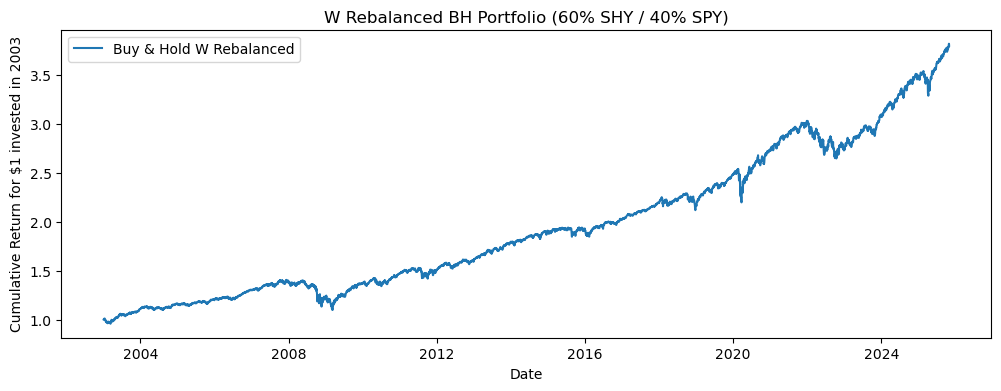

Final BH portfolio value: 3.795615039796364


In [7]:
bh_weights = pd.Series({"SHY": 0.6, "SPY": 0.4})
portfolio_value = 1.0
bh_cum_vals = []
print

rebalance_freq = 'W'  # weekly
rebalance_dates = returns.resample(rebalance_freq).last().index

w = bh_weights.copy()
for date, row in returns.iterrows():
    if date in rebalance_dates:
        # Reset weights to 60/40 weekly
        w = bh_weights.copy()

    # Compute daily return based on current weights
    r = (row[w.index] * w).sum()
    portfolio_value *= (1 + r)
    bh_cum_vals.append(portfolio_value)

# Create cumulative series
bh_cum = pd.Series(bh_cum_vals, index=returns.index)

# Plot
plt.figure(figsize=(12,4))
plt.plot(bh_cum, label="Buy & Hold " + rebalance_freq + " Rebalanced")
plt.title(rebalance_freq + " Rebalanced BH Portfolio (60% SHY / 40% SPY)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return for $1 invested in 2003")
plt.legend()
plt.show()
print("Final BH portfolio value:", bh_cum.iloc[-1])

## The CPPI strategy

<class 'pandas.core.series.Series'>
Date
2003-01-03    1.000123
2003-01-06    0.999513
2003-01-07    1.000245
2003-01-08    1.001098
2003-01-09    0.999269
dtype: float64


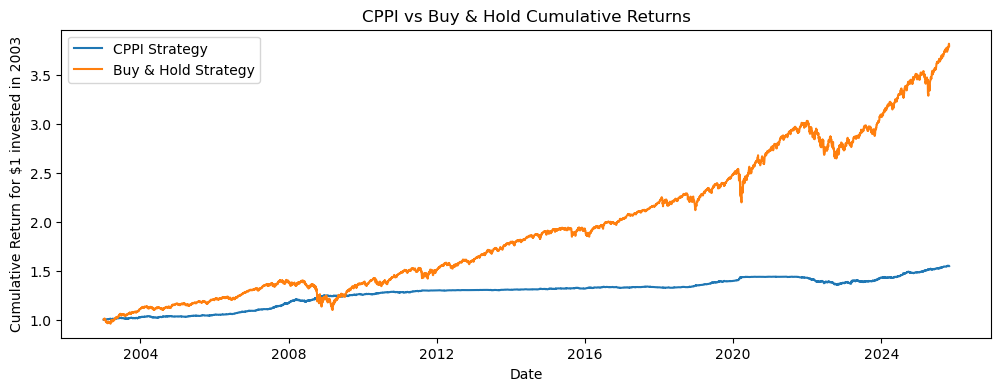

Final CPPI portfolio value: 1.5466782908161751
Final BH portfolio value: 3.795615039796364


In [8]:
# === PARAMETERS ===
m = 3
floor = 0.8
portfolio_value = 1.0
cppi_vals = []
weight_risky = []

# Ensure float columns
returns["SPY"] = returns["SPY"].astype(float)
returns["SHY"] = returns["SHY"].astype(float)

# Rebalance setup
rebalance_freq = "W"
rebalance_dates = set(returns.resample(rebalance_freq).first().index)

# Initialize weights
w = 0.0

for date, row in returns.iterrows():
    # Rebalance if needed
    if date in rebalance_dates:
        cushion = max(portfolio_value - floor, 0) / portfolio_value
        w = np.clip(m * cushion, 0, 1)
        w = float(w)

    # compute return r
    spy = float(row["SPY"])
    shy = float(row["SHY"])
    r = w * spy + (1 - w) * shy
    r = float(r)

    portfolio_value = float(portfolio_value * (1 + r))
    cppi_vals.append(portfolio_value)
    weight_risky.append(w)

strategy_cum = pd.Series(cppi_vals, index=returns.index)


print(type(strategy_cum))
print(strategy_cum.head())

plt.figure(figsize=(12,4))
plt.plot(strategy_cum.index, strategy_cum.values, label="CPPI Strategy")
plt.plot(bh_cum.index, bh_cum.values, label="Buy & Hold Strategy")
plt.title("CPPI vs Buy & Hold Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return for $1 invested in 2003")
plt.legend()
plt.show()

print("Final CPPI portfolio value:", strategy_cum.iloc[-1])
print("Final BH portfolio value:", bh_cum.iloc[-1])

### Why is the CPPI Strategy “Frozen”?

The CPPI strategy dynamically adjusts the allocation between a risky asset (SPY) and a safe asset (SHY) based on the **floor constraint** and the **risk multiplier m**.

When the portfolio value approaches the **floor level** (80% here), the cushion becomes zero. Consequently:

- The risky asset weight \(w\) approaches zero.
- The portfolio allocation shifts **entirely** into the safe asset.
- This **“freezes” the portfolio** for the entire time period so the portfolio value remains at the floor and is 100% composed of SHY (safe asset).

The CPPI portfolio did protect the capital but since it was frozen as soon as 2003, and no rebalancing made it so the portfolio did not participate in any market upside, leading to underperformance compared to the buy and hold strategy over the long term.


## Performance and metrics comparison

CPPI Strategy Performance Metrics (2003-oct 2025):
Sharpe Ratio             1.269151
Max Drawdown            -0.057071
Kurtosis                 7.399326
Skewness                 0.330221
Annualized Volatility    0.015165
VaR 95%                 -0.001311
CVaR 95%                -0.002110
dtype: float64
Buy & Hold Performance Metrics (2003-oct 2025):
Sharpe Ratio              0.834330
Max Drawdown             -0.218582
Kurtosis                 15.002893
Skewness                  0.032850
Annualized Volatility     0.073310
VaR 95%                  -0.006578
CVaR 95%                 -0.011025
dtype: float64
Safe Asset (SHY) Performance Metrics (2003-oct 2025):
Sharpe Ratio             1.269151
Max Drawdown            -0.057071
Kurtosis                 7.399326
Skewness                 0.330221
Annualized Volatility    0.015165
VaR 95%                 -0.001311
CVaR 95%                -0.002110
dtype: float64


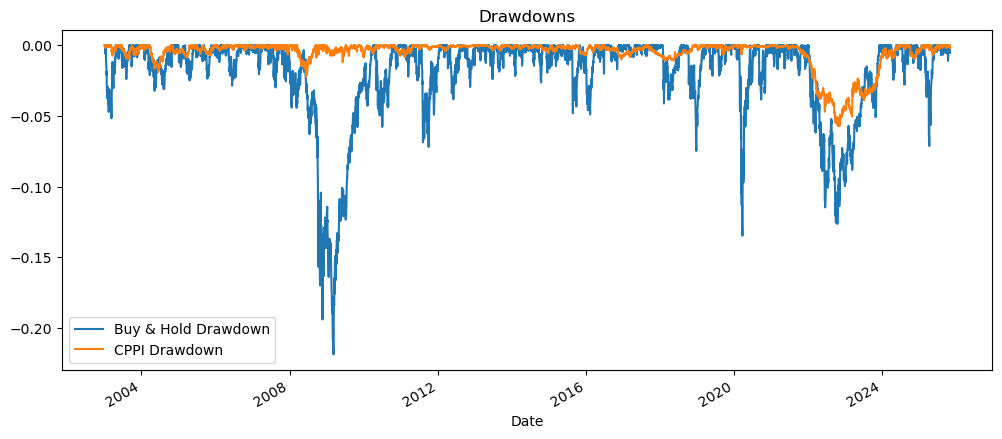

In [9]:
"""
The metrics used to evaluate the performance of the strategy vs buy & hold are:
    - Sharpe Ratio
    - Max Drawdown
    - Kurtosis
    - Skewness
    - Annualized Volatility
# ADD VALUE AT RISK (VaR) LATER
We do both annualized and whole period metrics for comparison.
"""
metrics_strategy = performance_metrics(strategy_cum)
metrics_bh = performance_metrics(bh_cum)
metrics_shy = performance_metrics(prices["SHY"].loc[strategy_cum.index])
print("CPPI Strategy Performance Metrics (2003-oct 2025):")
print(metrics_strategy)
print("Buy & Hold Performance Metrics (2003-oct 2025):")
print(metrics_bh)
print("Safe Asset (SHY) Performance Metrics (2003-oct 2025):")
print(metrics_shy)

# Drawdown plots
bh_dd = bh_cum / bh_cum.cummax() - 1
st_dd = strategy_cum / strategy_cum.cummax() - 1

plt.figure(figsize=(12,5))
bh_dd.plot(label="Buy & Hold Drawdown")
st_dd.plot(label="CPPI Drawdown")
plt.legend()
plt.title("Drawdowns")
plt.show()

We confirm that the CPPI strategy underperforms the buy and hold benchmark and has the same return profile as the safe asset (SHY) due to being frozen early on.

### The question becomes:
- Could a different floor level or risk multiplier have improved performance?
- Could the implementation of a rebalancing for the CPPI portfolio have improved performance?

If so, by how much, what cost in terms of risk and the optimal parameters?

## Sensitivity Analysis

We analyze the sensitivity of the CPPI strategy performance to different floor levels, risk multipliers and rebalancing frequencies.

Safe (floor, multiplier) combinations:
[(0.5, 1), (0.5, 1.5), (0.55, 1), (0.55, 1.5), (0.55, 2), (0.6, 1), (0.6, 1.5), (0.6, 2), (0.65, 1), (0.65, 1.5), (0.65, 2), (0.65, 2.5), (0.7, 1), (0.7, 1.5), (0.7, 2), (0.7, 2.5), (0.7, 3), (0.75, 1), (0.75, 1.5), (0.75, 2), (0.75, 2.5), (0.75, 3), (0.75, 3.5), (0.8, 1), (0.8, 1.5), (0.8, 2), (0.8, 2.5), (0.8, 3), (0.8, 3.5), (0.8, 4), (0.8, 4.5), (0.85, 1), (0.85, 1.5), (0.85, 2), (0.85, 2.5), (0.85, 3), (0.85, 3.5), (0.85, 4), (0.85, 4.5), (0.85, 5), (0.9, 1), (0.9, 1.5), (0.9, 2), (0.9, 2.5), (0.9, 3), (0.9, 3.5), (0.9, 4), (0.9, 4.5), (0.9, 5), (0.95, 1), (0.95, 1.5), (0.95, 2), (0.95, 2.5), (0.95, 3), (0.95, 3.5), (0.95, 4), (0.95, 4.5), (0.95, 5)]


C:\Users\Gus\AppData\Local\Temp\ipykernel_24272\1019227685.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


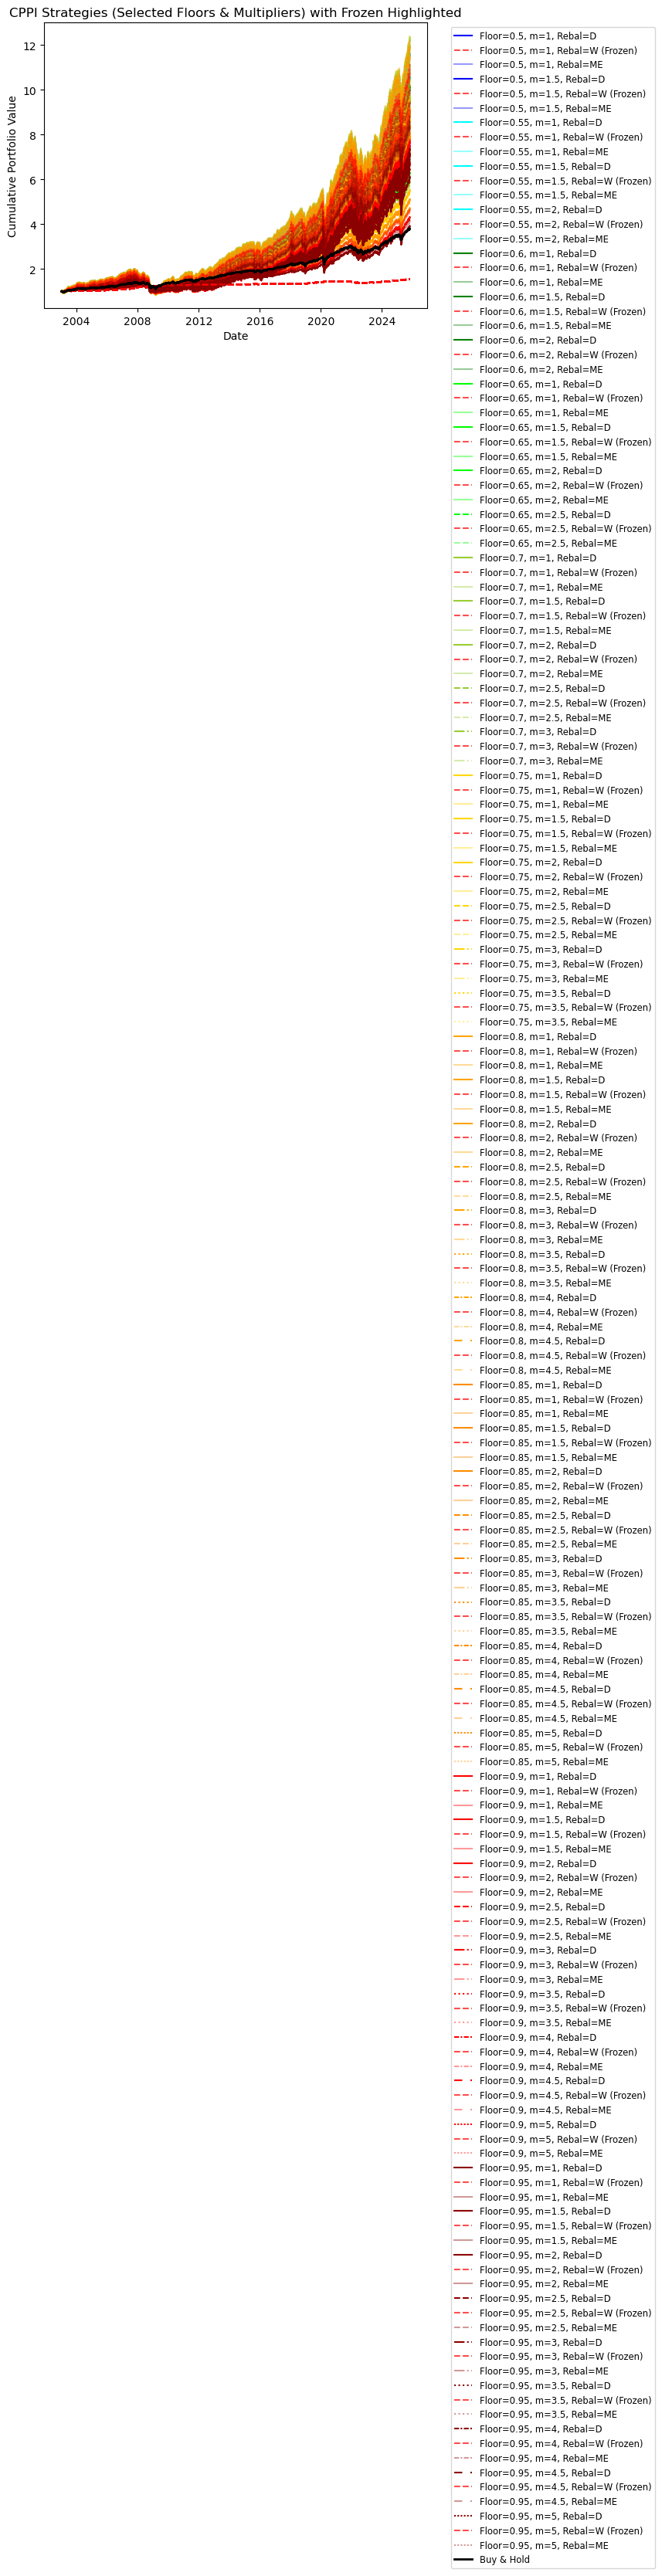

Best CPPI Strategies by Final Portfolio Value:
     floor    m rebalance  final_value  frozen_fraction
92    0.80  4.5        ME    12.274171         0.003308
50    0.70  3.0        ME    12.248758         0.003308
68    0.75  3.5        ME    12.235333         0.003308
14    0.55  2.0        ME    12.161402         0.003308
35    0.65  2.5        ME    12.151006         0.003308
89    0.80  4.0        ME    12.093905         0.003308
119   0.85  5.0        ME    12.046100         0.003308
23    0.60  2.0        ME    11.862137         0.003308
65    0.75  3.0        ME    11.832865         0.003308
116   0.85  4.5        ME    11.769220         0.003308


In [10]:
# Sensitivity Analysis
# Caution: This may take a while to run
from utils import floor_colors, multiplier_styles, rebalance_alpha

# --- Sensitivity analysis --- on all these combinations
floor_values = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.90, 0.95]
multipliers = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
rebalance_frequencies = ['D', 'W', 'ME']

results = []
frozen_strategies = []

# Safe combinations: m * (1 - floor) < 0.999 cause rounding issues with 1
safe_combinations = [(floor, m) 
                     for floor in floor_values 
                     for m in multipliers 
                     if m * (1 - floor) < 0.999]

print("Safe (floor, multiplier) combinations:")
print(safe_combinations)

for floor, m in safe_combinations:  # iterate only over safe combinations
    for freq in rebalance_frequencies:
        strategy_cum, weights = run_cppi(returns, floor=floor, m=m, rebalance_freq=freq)
        
        frozen, frac = check_frozen(weights)
        
        # Append to results
        results.append({
            "floor": floor,
            "m": m,
            "rebalance": freq,
            "final_value": strategy_cum.iloc[-1],
            "frozen_fraction": frac
        })
        
        # Append to frozen_strategies if frozen
        if frozen:
            frozen_strategies.append({
                "floor": floor,
                "m": m,
                "rebalance": freq,
                "final_value": strategy_cum.iloc[-1],
                "frozen_fraction": frac
            })
        
        # Plot all safe combinations
        line_color = 'red' if frozen else floor_colors.get(floor, "gray")
        line_style = '--' if frozen else multiplier_styles.get(m, '-')
        label = f"Floor={floor}, m={m}, Rebal={freq}" + (" (Frozen)" if frozen else "")
        plt.plot(strategy_cum.index, strategy_cum.values,
                 color=line_color,
                 linestyle=line_style,
                 alpha=rebalance_alpha[freq],
                 label=label)

# Plot Buy & Hold for reference
plt.plot(bh_cum.index, bh_cum.values, color='black', linewidth=2, label="Buy & Hold")

plt.title("CPPI Strategies (Selected Floors & Multipliers) with Frozen Highlighted")
plt.xlabel("Date")
plt.ylabel("Cumulative Portfolio Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

# Print the best results
print("Best CPPI Strategies by Final Portfolio Value:")
results_df = pd.DataFrame(results)
best_strategies = results_df.sort_values(by="final_value", ascending=False).head(10)
print(best_strategies)

### Analysis

A number of CPPI parameter combinations outperform the 60/40 buy-and-hold benchmark over the 2003–2025 sample.
However, many of these strategies end with almost identical final portfolio values, and this is not accidental.
This happens because for those parameter settings:

The cushion becomes large very early (due to strong equity performance), the CPPI formula allocates the maximum possible exposure to the risky asset (100% SPY),and the portfolio stays fully invested in SPY for most of the sample.

Once the portfolio reaches the point where:

    𝑤 = min⁡(1,𝑚×cushion) = 1,

The CPPI strategy behaves almost exactly like a pure SPY buy-and-hold.
Since many parameter combinations reach this state early and remain there, they all accumulate nearly the same final portfolio value, explaining why results cluster together at 12.298 final value.

## The frozen strategies

In [11]:
# List of the frozen strategies

print("Frozen CPPI Strategies:")
frozen_df = pd.DataFrame(frozen_strategies)
print(frozen_df)

Frozen CPPI Strategies:
    floor    m rebalance  final_value  frozen_fraction
0    0.50  1.0         W     1.546678              1.0
1    0.50  1.5         W     1.546678              1.0
2    0.55  1.0         W     1.546678              1.0
3    0.55  1.5         W     1.546678              1.0
4    0.55  2.0         W     1.546678              1.0
5    0.60  1.0         W     1.546678              1.0
6    0.60  1.5         W     1.546678              1.0
7    0.60  2.0         W     1.546678              1.0
8    0.65  1.0         W     1.546678              1.0
9    0.65  1.5         W     1.546678              1.0
10   0.65  2.0         W     1.546678              1.0
11   0.65  2.5         W     1.546678              1.0
12   0.70  1.0         W     1.546678              1.0
13   0.70  1.5         W     1.546678              1.0
14   0.70  2.0         W     1.546678              1.0
15   0.70  2.5         W     1.546678              1.0
16   0.70  3.0         W     1.546678    

## Interpretation of the results of frozen strategies

SPY had a negative return over the first few weeks of 2003.
We can see that only the weekly rebalancing is the only frequency that systematically freezes the CPPI strategy.  
It reacts too slowly to early-period losses, so by the first or second weekly rebalance, the portfolio value has already dropped below the floor level.  
Once this happens, the cushion becomes zero and the strategy assigns: 0% risky asset, and because weight updates only occur weekly, the CPPI remains permanently stuck in a risk-off state.

**CPPI Freeze Behavior by Rebalancing Frequency**

| Frequency | Behavior       | Explanation |
|----------|----------------|-------------|
| **Daily**   | *Not frozen* | Cushion updated frequently → avoids falling below floor → escapes floor trap |
| **Weekly**  | **Always frozen** | Rebalances too late → early 2003 drawdown pushes PV below floor → w = 0 forever |
| **Monthly** | *Not frozen* | Larger gaps between rebalances allow SPY recovery → PV rises above floor again |

So the key insight is that **more frequent rebalancing helps the CPPI strategy avoid getting stuck below the floor during short-term market downturns**.

## Analysis of best performing strategies

Many startegies that outperform the buy and hold benchmark do so by reaching a state of full investment in SPY early on and remaining there. So let's tweek the simulation so that once the CPPI reaches full investment in SPY, it is forced to rebalance periodically to reduce exposure and lock in gains.

So now we will implement a modified CPPI strategy where once the risky asset weight hits 100%, the portfolio is rebalanced at the specified frequency to gradually reduce exposure to SPY and lock in gains.

This is called a dynamic (ratcheting) floor strategy.

C:\Users\Gus\AppData\Local\Temp\ipykernel_24272\357611460.py:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


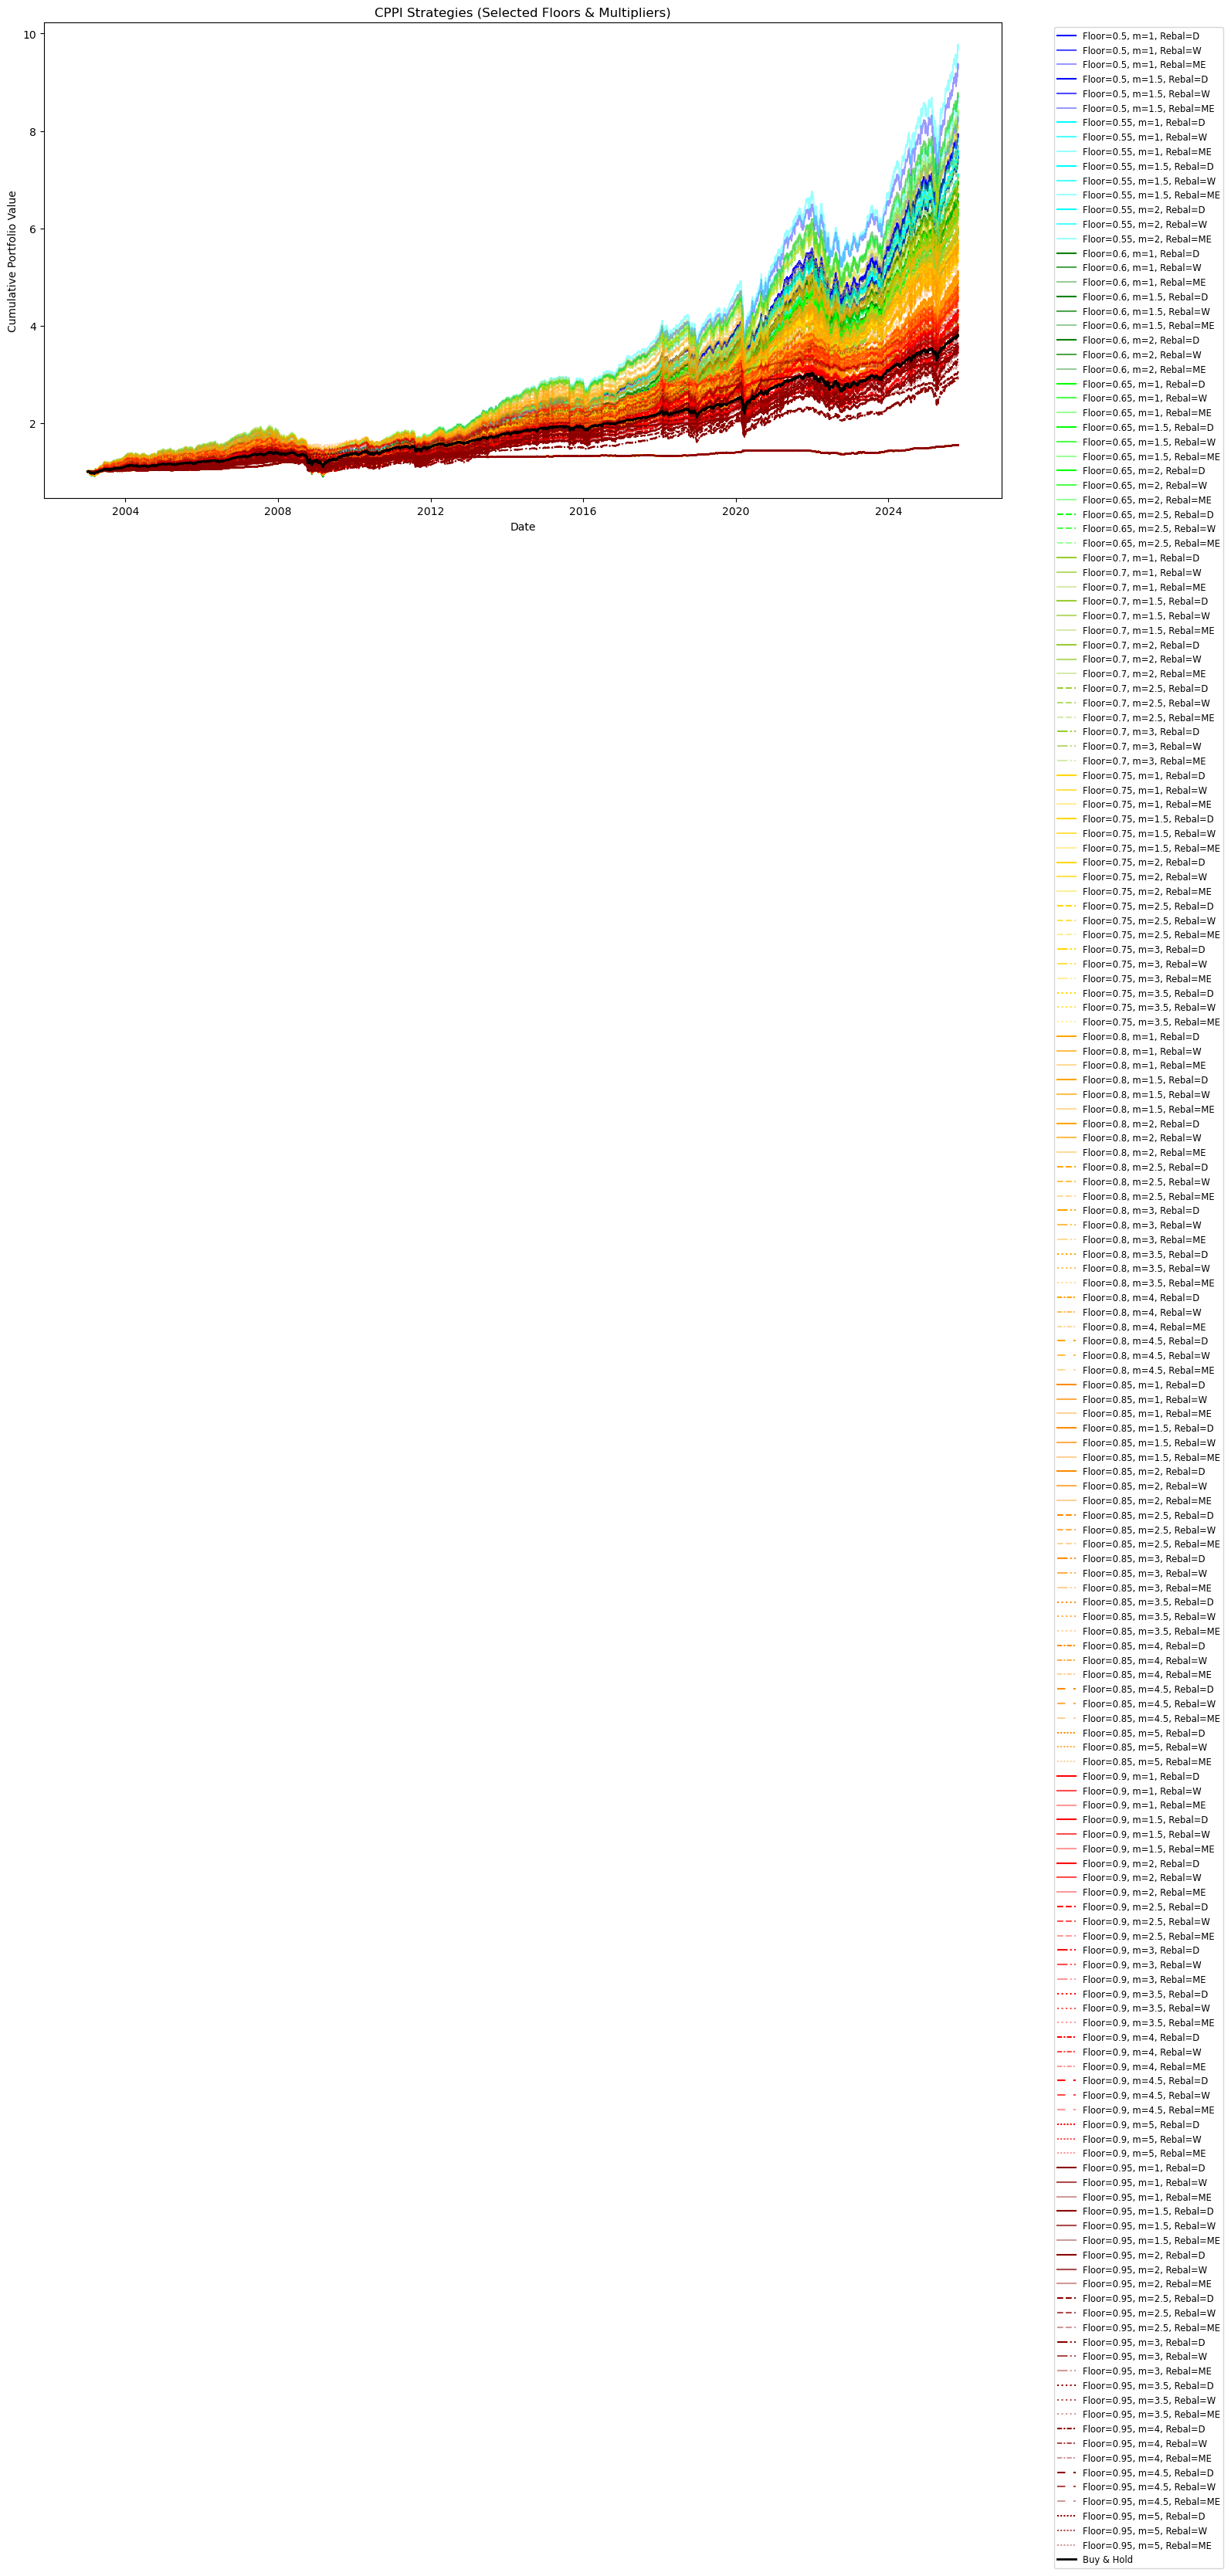

Best strategies by final portfolio value:
    floor    m rebalance  final_value  num_rebalances
14   0.55  2.0        ME     9.670622             193
5    0.50  1.5        ME     9.278011             193
35   0.65  2.5        ME     8.701525             193
23   0.60  2.0        ME     8.696551             193
11   0.55  1.5        ME     8.624461             193
50   0.70  3.0        ME     8.370400             193
32   0.65  2.0        ME     8.310701             193
2    0.50  1.0        ME     8.201131             193
47   0.70  2.5        ME     8.040921             193
65   0.75  3.0        ME     8.023163             193


In [12]:
results = []

plt.figure(figsize=(16, 8))

# Precompute safe combinations
safe_combinations = [(floor, m) 
                     for floor in floor_values 
                     for m in multipliers 
                     if m * (1 - floor) < 0.999]  # slightly below 1 to avoid FP issues

for floor, m in safe_combinations:
    for freq in rebalance_frequencies:
        # Run CPPI with forced periodic adjustment
        strategy_cum, weights = run_cppi_dynamic_floor(returns, floor=floor, m=m, rebalance_freq=freq)
        
        # Count rebalances
        rebalance_dates = set(returns.resample(freq).first().index)
        num_rebalances = sum([1 for date in returns.index if date in rebalance_dates])
        
        # Compute final value
        final_value = strategy_cum.iloc[-1]
        
        # Save results
        results.append({
            "floor": floor,
            "m": m,
            "rebalance": freq,
            "final_value": final_value,
            "num_rebalances": num_rebalances
        })
        
        # Plot all safe combinations
        label = f"Floor={floor}, m={m}, Rebal={freq}"
        plt.plot(strategy_cum.index, strategy_cum.values,
                    color=floor_colors.get(floor, "gray"),
                    linestyle=multiplier_styles.get(m, '-'),
                    alpha=rebalance_alpha[freq],
                    label=label)

# Plot Buy & Hold for reference
plt.plot(bh_cum.index, bh_cum.values, color='black', linewidth=2, label="Buy & Hold")

plt.title("CPPI Strategies (Selected Floors & Multipliers)")
plt.xlabel("Date")
plt.ylabel("Cumulative Portfolio Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

# Show best strategies by final value
results_df = pd.DataFrame(results)
best_strategies = results_df.sort_values(by="final_value", ascending=False).head(10)
print("Best strategies by final portfolio value:")
print(best_strategies[["floor", "m", "rebalance", "final_value", "num_rebalances"]])


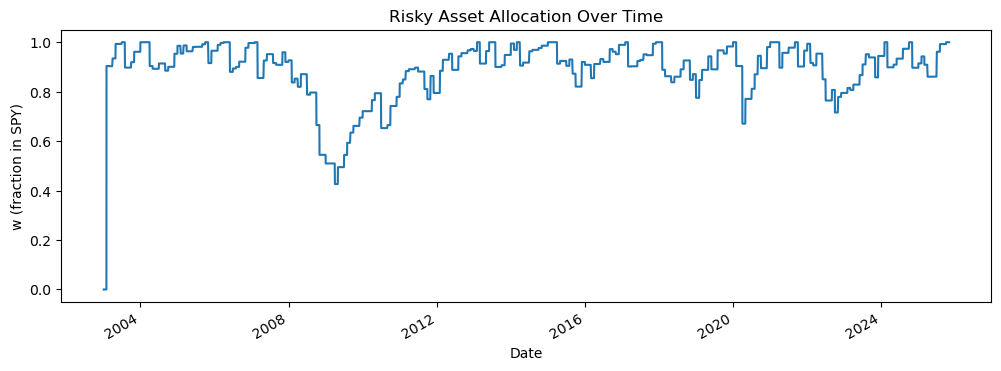

In [13]:
# We do a deep dive into the rebalanced dynamic floor strategy for the best performing startegy

strategy_cum, weights = run_cppi_dynamic_floor(returns, floor=0.55, m=2, rebalance_freq='ME')
pd.Series(weights, index=returns.index).plot(figsize=(12,4))
plt.title("Risky Asset Allocation Over Time")
plt.ylabel("w (fraction in SPY)")
plt.show()

We can see how the allocation to the risky asset (SPY) changes over time with the dynamic floor strategy.

We can also observe that this plot (from the best strategy) shows that the allocation to SPY is very close to 100% for most of the time period, makjing it so that the CPPI strategy effectively behaves like a buy and hold of the SPY for most of the sample, explaining its strong performance.

Some of the gaps in the allocation to SPY correspond to market downturns where the CPPI reduces exposure to lock in gains (e.g., the 2008 financial crisis and the 2020 COVID crash).

# Conclusion

This analysis explored CPPI strategies versus a Buy & Hold benchmark over 2003–2025, highlighting how floor level, multiplier, and rebalancing frequency affect performance. Key takeaways:

Frozen portfolios: Weekly rebalancing can freeze CPPI strategies early when the cushion hits zero, leaving the portfolio fully in the safe asset and missing market upside. Daily or monthly rebalancing avoids this.

Best-performing strategies: Aggressive floors and multipliers that reach full risky allocation early behave almost like SPY buy-and-hold, giving strong performance but with high risk.

Dynamic floor / ratcheting strategy: Resetting the floor once fully invested in the risky asset allows locking in gains while gradually reducing risk, improving CPPI performance.

**Overall:** CPPI can outperform Buy & Hold under some chosen parameters and frequent enough rebalancing. However, some rebalancing parameters can freeze the portfolio or mimic a pure equity buy-and-hold. Dynamic floors mitigate risk while capturing upside.

Future work could explore risk-adjusted returns, transaction costs from rebalancing, and alternative assets for the risky and safe assets.
